In [38]:
import numpy as np
import scipy.stats as scs
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from tqdm import tqdm
from scipy.spatial.distance import pdist
plt.rcParams.update({'font.size': 30})

In [91]:
# Generate 50 variables from a standard Gaussian distribution
z_1 = np.random.normal(size=50)

# Generate 50 variables from another standard Gaussian distribution
z_2 = np.random.normal(size=50)

# Generate 50 variables from a Gamma(2,3) distribution
z_3 = np.random.normal(size=50)

# make a predictor matrix
z_matrix = np.column_stack((z_1, z_2, z_3))

# parameters
theta_star = np.array([0,-0.5,1.3])

# outcome variable
y = np.random.multivariate_normal(mean=np.matmul(z_matrix , theta_star ), cov=np.eye(50))

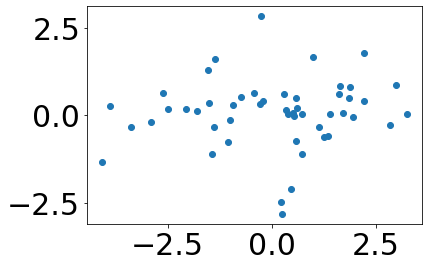

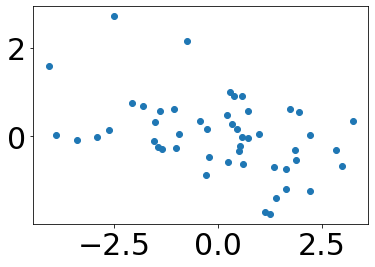

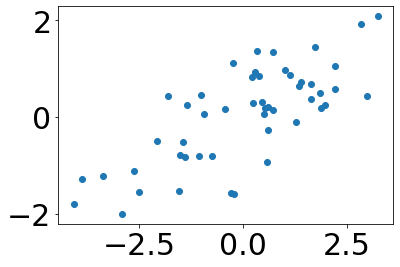

In [92]:
plt.scatter(y,z_1)
plt.show()
plt.scatter(y,z_2)
plt.show()
plt.scatter(y,z_3)
plt.show()

In [139]:
# Energy Score

def Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy


Energy_Score(1,[np.random.normal(size=50)],np.random.multivariate_normal(mean=np.zeros(50),cov=np.eye(50),size=10))

9.323613748404858

In [225]:
# ABC

def ABC(iter,Z_mat,obs):

    out = []

    for m in tqdm(range(iter)):

        # select model
        model = np.random.choice([0,1], size=3,replace=True)
        theta = [np.random.normal(), np.random.normal(), np.random.gamma(shape=2, scale=1)]
        draw = np.random.multivariate_normal(mean=np.matmul(Z_mat , np.multiply(theta,model) ), cov=np.eye(50),size=10)
        SR = Energy_Score(1,obs,draw)

        out.append(np.array([np.array(model),np.array(theta),np.array(SR)]))

    return out

abc_run = np.array(ABC(500000,z_matrix,y))

  0%|          | 0/500000 [00:00<?, ?it/s]C:\Users\u1819911\AppData\Local\Temp\ipykernel_15616\800696887.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out.append(np.array([np.array(model),np.array(theta),np.array(SR)]))
100%|██████████| 500000/500000 [03:31<00:00, 2367.06it/s]


In [299]:
abc_sorted_by_SR = abc_run[abc_run[:,2].argsort()]
abc_sorted_by_SR
# save
import pickle
with open('abc_values.txt','wb') as f:
    pickle.dump(abc_sorted_by_SR,f)

'''
# load
import pickle
with open('SR_values.txt','rb') as f:
    t = pickle.load(f)'''

"\n\n# load\nimport pickle\nwith open('SR_values.txt','rb') as f:\n    t = pickle.load(f)"

In [381]:
500000*0.05

25000.0

[ 0.   22.02  0.   61.24  0.    3.56  0.   13.18]


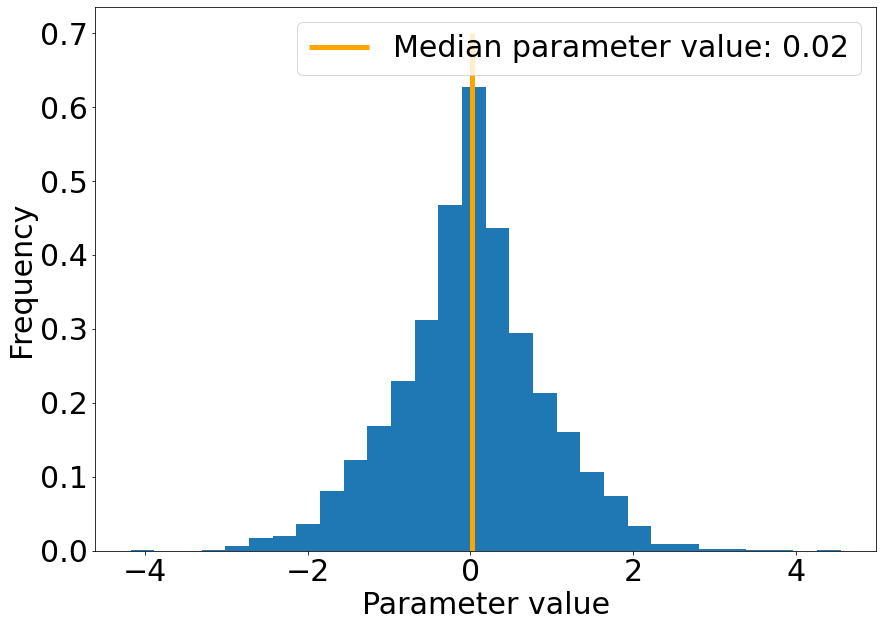

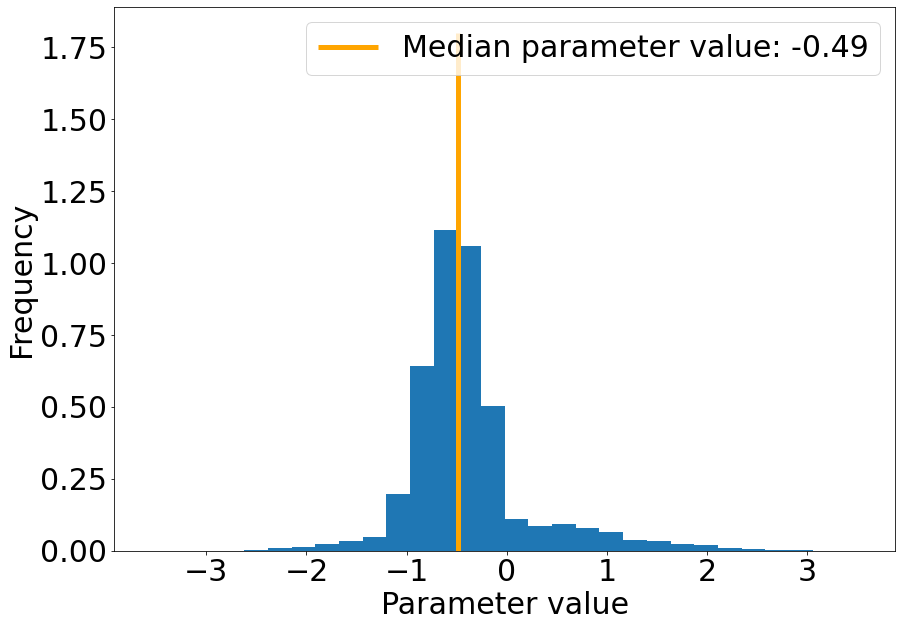

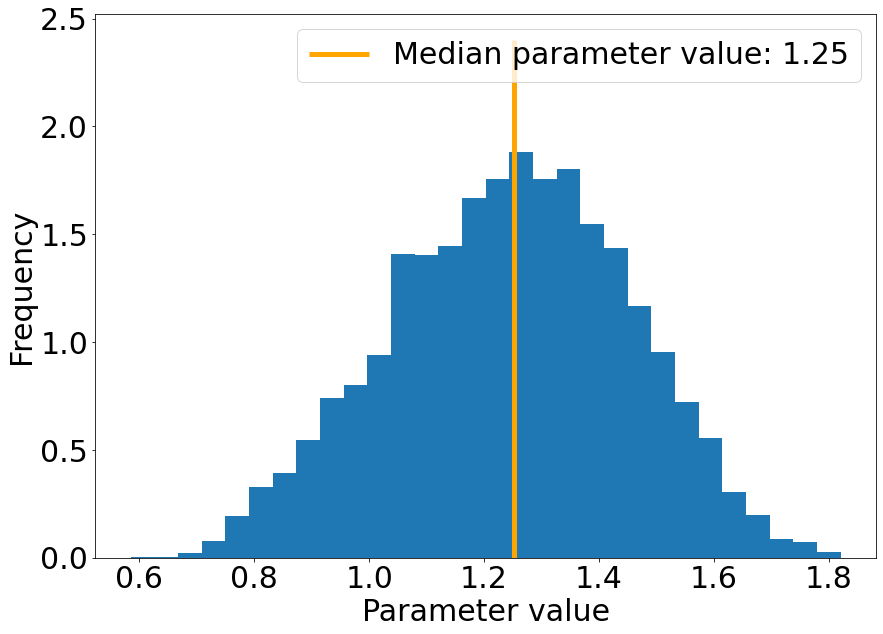

In [386]:
# Plots

# models
models = np.zeros(8)
for i in range(len(abc_sorted_by_SR[:5000])):
    if all(abc_sorted_by_SR[i,0]==[0,0,0]):
        models[0]+=1
    if all(abc_sorted_by_SR[i,0]==[0,0,1]):
        models[1]+=1  
    if all(abc_sorted_by_SR[i,0]==[0,1,0]):
        models[2]+=1
    if all(abc_sorted_by_SR[i,0]==[0,1,1]):
        models[3]+=1
    if all(abc_sorted_by_SR[i,0]==[1,0,0]):
        models[4]+=1
    if all(abc_sorted_by_SR[i,0]==[1,0,1]):
        models[5]+=1
    if all(abc_sorted_by_SR[i,0]==[1,1,0]):
        models[6]+=1
    if all(abc_sorted_by_SR[i,0]==[1,1,1]):
        models[7]+=1

print(models/5000 *100)

# theta
M = 5000
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.hist([abc_sorted_by_SR[i][1][0] for i in range(M)],bins=30,density=True)
plt.vlines(np.median([abc_sorted_by_SR[i][1][0] for i in range(M)]),ymin=0,ymax=0.7,color='orange',linewidth=5,label='Median parameter value: '+str(round(np.median([abc_sorted_by_SR[i][1][0] for i in range(M)]),2)))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Parameter value')
plt.show()

fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.hist([abc_sorted_by_SR[i][1][1] for i in range(M)],bins=30,density=True)
plt.vlines(np.median([abc_sorted_by_SR[i][1][1] for i in range(M)]),ymin=0,ymax=1.8,color='orange',linewidth=5,label='Median parameter value: '+str(round(np.median([abc_sorted_by_SR[i][1][1] for i in range(M)]),2)))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Parameter value')
plt.show()

fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.hist([abc_sorted_by_SR[i][1][2] for i in range(M)],bins=30,density=True)
plt.vlines(np.median([abc_sorted_by_SR[i][1][2] for i in range(M)]),ymin=0,ymax=2.4,color='orange',linewidth=5,label='Median parameter value: '+str(round(np.median([abc_sorted_by_SR[i][1][2] for i in range(M)]),2)))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Parameter value')
plt.show()